<a href="https://colab.research.google.com/github/yamrajkhadka/Land-Cover-Classification-from-Satellite-Images-using-U-Net-on-the-DeepGlobe-Dataset/blob/main/500_epoch_unet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary libraries
!pip install kaggle
# Set up Kaggle API credentials
import os
os.environ['KAGGLE_USERNAME'] = 'yamrajkhadka01'
os.environ['KAGGLE_KEY'] = '/content/kaggle (5).json'
# Download the dataset
!kaggle datasets download -d balraj98/deepglobe-land-cover-classification-dataset -p /content/
# Unzip the dataset
!unzip -q /content/deepglobe-land-cover-classification-dataset.zip -d /content/deepglobe_dataset/

Dataset URL: https://www.kaggle.com/datasets/balraj98/deepglobe-land-cover-classification-dataset
License(s): other
100% 2.73G/2.74G [00:25<00:00, 39.7MB/s]
100% 2.74G/2.74G [00:25<00:00, 114MB/s] 


In [ ]:


import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [ ]:


# 1. Load class color mapping as ml doesnot understand the rgb(i.e color) so need, to convert to class label
class_dict = pd.read_csv('/content/deepglobe_dataset/class_dict.csv')
color2class = {(row['r'], row['g'], row['b']): idx for idx, row in class_dict.iterrows()}  #..urban_land's rgb(0,255,255)sky like color is class level 0
NUM_CLASSES = len(class_dict)

def rgb_to_class(mask_rgb):  #mask_rgb(input) is a img where each pixel means land type
    h, w, _ = mask_rgb.shape
    mask_class = np.zeros((h, w), dtype=np.uint8) #blank mask ,later we fill with landtype
    for color, class_idx in color2class.items():  #here the color represent the (0,255,255) and class_idx represent corresponding 0..
        matches = np.all(mask_rgb == color, axis=-1)  #np.all means check if all the value are true along the direction and return true and false.
        #say mask_rgb[10][20] is a pixel of (0,255,255)->cyan->urban->0 idx ||| check every pixel in rgb_mask with all class label .. it Creates a 2D array where every pixel stores the class number
        mask_class[matches] = class_idx

    return mask_class #it is a 2D array (height × width),where each position holds one integer

def class_to_rgb(mask_class): #for visualization
    h, w = mask_class.shape
    mask_rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for color, class_idx in color2class.items():
        mask_rgb[mask_class == class_idx] = color #assign the rgb if same
    return mask_rgb

let us conider this mask_image 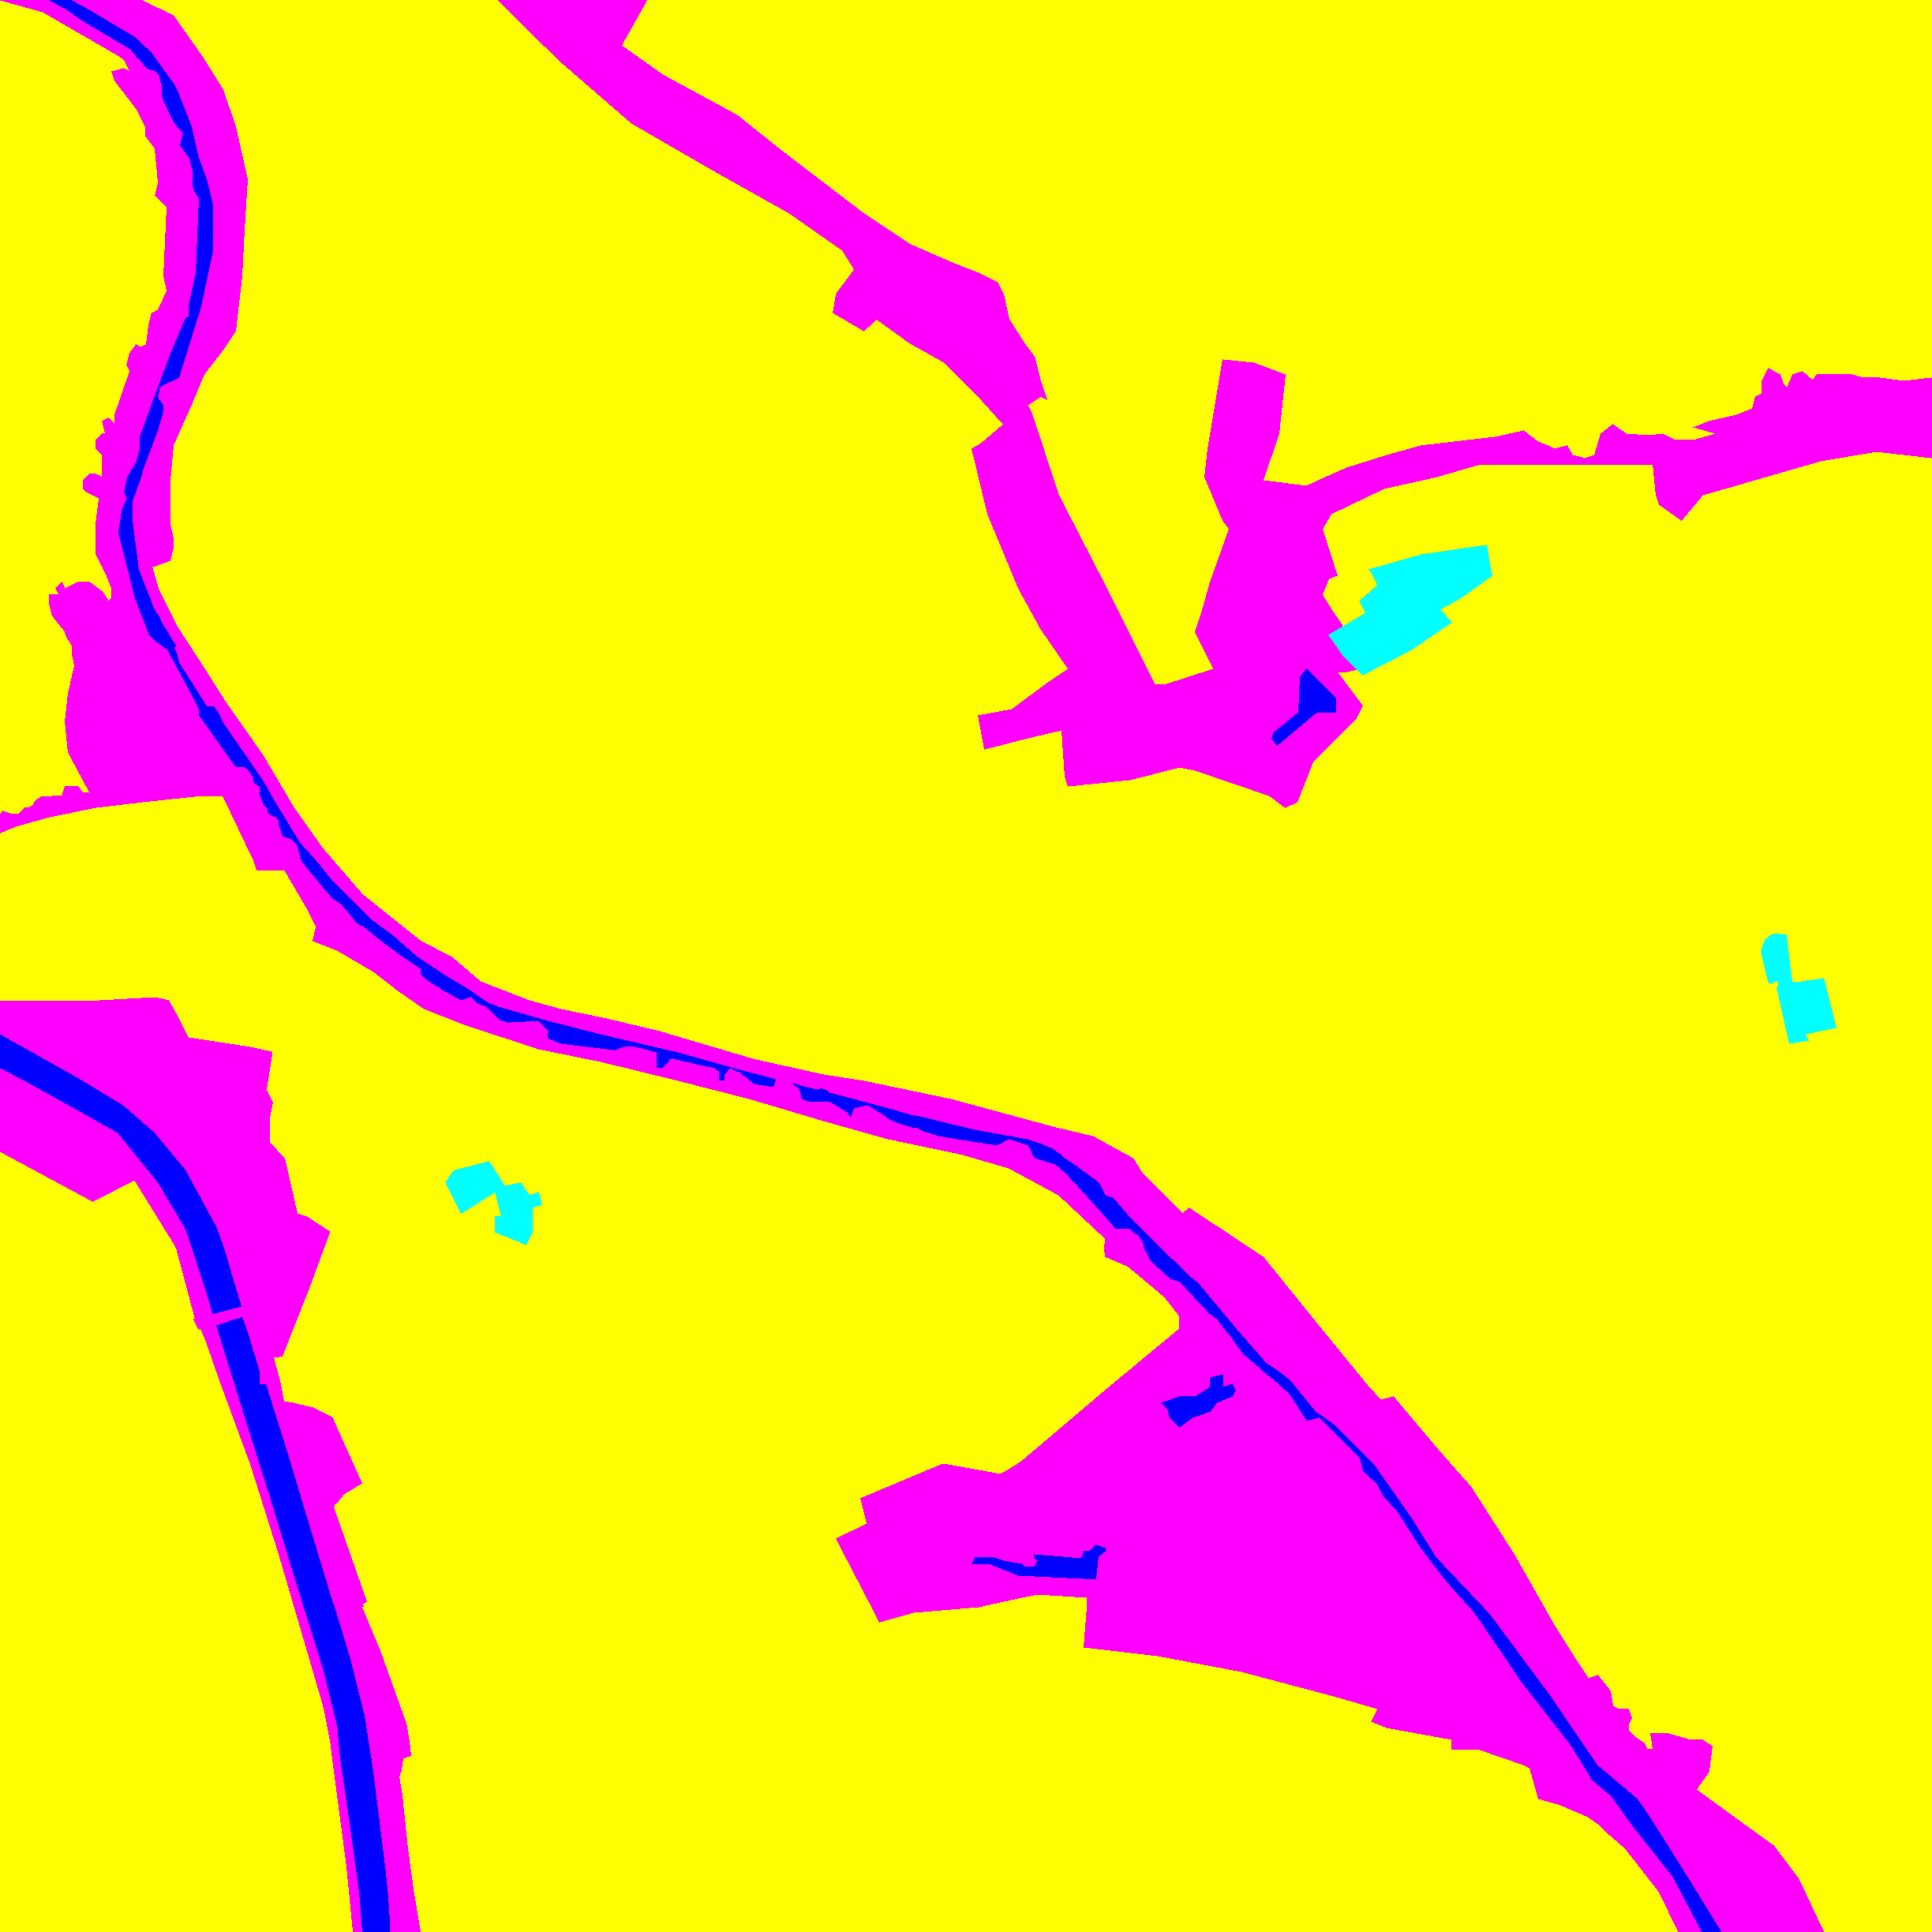


# Get the total number of pixels in the image
total_pixels = mask_rgb.shape[0] * mask_rgb.shape[1]:4194304



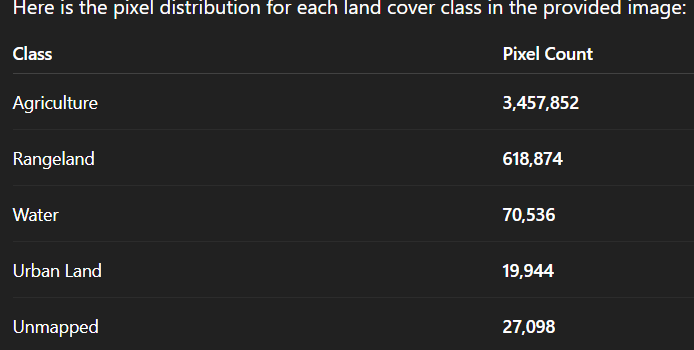

let us take a pixel[150][300]..this is yellow(255,255,0)->1 class label->agriculure land


for the 1st iteration. color=(0, 255, 255) → urban land ,
Check:[255 == 0, 255 == 255, 0 == 255] → [False, True, False]
np.all(...) → False →No Match

similarly,Iteration 2
color = (255, 255, 0) → agriculture
Check:
[255 == 255, 255 == 255, 0 == 0] → [True, True, True]
np.all(...) → True → Match!
np.all, mask_class[150][300] = 1   #similarly for other np.all ->false
Hence,mask_class[150][300] = 1  # Agriculture (Yellow)

In [ ]:


# 2. Load and preprocess more data
TRAIN_IMG_DIR = '/content/deepglobe_dataset/train'
IMG_SIZE = (128, 128)  #setting the img size
img_ids = [f[:-8] for f in os.listdir(TRAIN_IMG_DIR) if f.endswith('_sat.jpg')] #to extract [abc,def..] later used to load both the img->(f"{img_id}_sat.jpg")and mask(f"{img_id}_mask.png")
N = min(500, len(img_ids))  # Use up to 500 images if available...prevent to loading to much data in training

X, Y = [], []
for img_id in img_ids[:N]:
    img = cv2.imread(os.path.join(TRAIN_IMG_DIR, f"{img_id}_sat.jpg")) # here os.path.join combine the folder path with the file name and imread convert image into numby array
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0 #normalization to convrge nn faster
    mask = cv2.imread(os.path.join(TRAIN_IMG_DIR, f"{img_id}_mask.png"))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    mask = cv2.resize(mask, IMG_SIZE, interpolation=cv2.INTER_NEAREST) #resizing the size to mask to the i/p img using inter-nearest(just copy nearest pixel)
    mask_class = rgb_to_class(mask)
    mask_onehot = to_categorical(mask_class, num_classes=NUM_CLASSES)
    X.append(img)
    Y.append(mask_onehot)
X = np.array(X)
Y = np.array(Y)  #convert the list to numpy array for training
print("X shape:", X.shape, "Y shape:", Y.shape)

X shape: (500, 128, 128, 3) Y shape: (500, 128, 128, 7)


In [ ]:


# 3. U-Net model
def build_unet(input_shape=(128, 128, 3), num_classes=NUM_CLASSES):
    inputs = Input(input_shape)
    c1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(64, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(64, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)

    c3 = Conv2D(128, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(128, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D()(c3)

    b = Conv2D(256, 3, activation='relu', padding='same')(p3)
    b = Dropout(0.3)(b)

    u1 = Conv2DTranspose(128, 2, strides=2, padding='same')(b)
    u1 = concatenate([u1, c3])
    c4 = Conv2D(128, 3, activation='relu', padding='same')(u1)
    c4 = Conv2D(128, 3, activation='relu', padding='same')(c4)

    u2 = Conv2DTranspose(64, 2, strides=2, padding='same')(c4)
    u2 = concatenate([u2, c2])
    c5 = Conv2D(64, 3, activation='relu', padding='same')(u2)
    c5 = Conv2D(64, 3, activation='relu', padding='same')(c5)

    u3 = Conv2DTranspose(32, 2, strides=2, padding='same')(c5)
    u3 = concatenate([u3, c1])
    c6 = Conv2D(32, 3, activation='relu', padding='same')(u3)
    c6 = Conv2D(32, 3, activation='relu', padding='same')(c6)

    outputs = Conv2D(num_classes, 1, activation='softmax')(c6)
    return Model(inputs, outputs)

model = build_unet()
model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=NUM_CLASSES)])
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │    131,200 │ dropout[0][0]     │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    295,040 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_7[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 64, 64,    │     32,832 │ conv2d_8[0][0]  

 Total params: 1,335,719 (5.10 MB)

 Trainable params: 1,335,719 (5.10 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# 4. Train
history = model.fit(X, Y, validation_split=0.2, epochs=500, batch_size=8)

Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 145ms/step - accuracy: 0.5152 - loss: 1.5274 - mean_io_u: 0.4286 - val_accuracy: 0.5164 - val_loss: 1.4645 - val_mean_io_u: 0.4286
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.5873 - loss: 1.3472 - mean_io_u: 0.4286 - val_accuracy: 0.5164 - val_loss: 1.4494 - val_mean_io_u: 0.4286
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.6136 - loss: 1.2890 - mean_io_u: 0.4286 - val_accuracy: 0.5164 - val_loss: 1.4302 - val_mean_io_u: 0.4286
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.6065 - loss: 1.2673 - mean_io_u: 0.4286 - val_accuracy: 0.5334 - val_loss: 1.4230 - val_mean_io_u: 0.4286
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.6607 - loss: 1.1279 - mean_io_u: 0.4286 - val_accuracy: 0.5338 - val_loss: 1.3439 - val_mean_io_u: 0.4286
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.6397 - loss: 1.1442 - mean_io_u: 0.4286 - val_accuracy: 0.5474 - val_los

Showing predictions for 3 random images:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


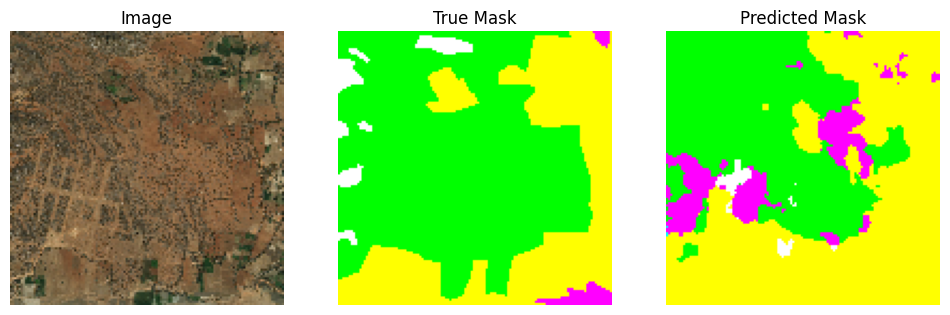

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


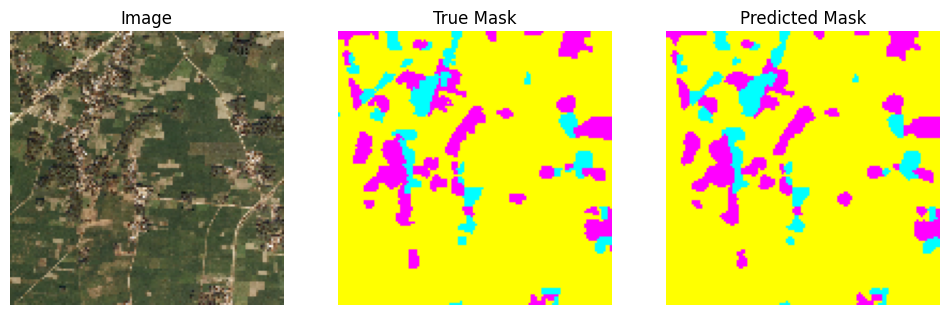

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


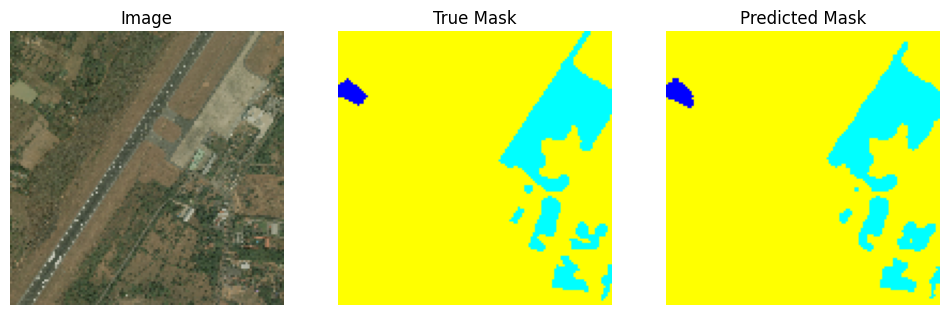

In [ ]:
# 5. Visualize predictions
def show_pred(i):
    img = X[i]
    true_mask = class_to_rgb(np.argmax(Y[i], axis=-1))

    pred = model.predict(np.expand_dims(img, 0))[0] # Converting a (single image → batch input)...as dl expects batch attach even for 1 img..then,→ model prediction → readable output


    pred_mask = class_to_rgb(np.argmax(pred, axis=-1))
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); plt.imshow(img); plt.title('Image'); plt.axis('off')
    plt.subplot(1, 3, 2); plt.imshow(true_mask); plt.title('True Mask'); plt.axis('off')
    plt.subplot(1, 3, 3); plt.imshow(pred_mask); plt.title('Predicted Mask'); plt.axis('off')
    plt.show()

print("Showing predictions for 3 random images:")
for i in np.random.choice(len(X), 3, replace=False):
    show_pred(i)

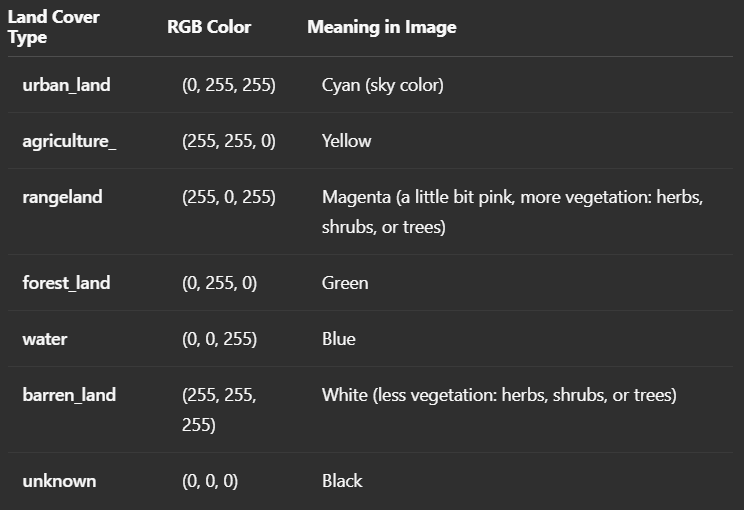

In [ ]:
# 6. Save model
model.save('deepglobe_unet_better.h5')
print("Model saved as 'deepglobe_unet_better.h5'")

Model saved as 'deepglobe_unet_better.h5'
